# Project 2: Breakout Strategy
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. After implementing the function, run the cell to test it against the unit tests we've provided. For each problem, we provide one or more unit tests from our `project_tests` package. These unit tests won't tell you if your answer is correct, but will warn you of any major errors. Your code will be checked for the correct solution when you submit it to Udacity.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `helper`, `project_helper`, and `project_tests`. These are custom packages built to help you solve the problems.  The `helper` and `project_helper` module contains utility functions and graph functions. The `project_tests` contains the unit tests for all the problems.

### Install Packages

### Load Packages

In [1]:
import pandas as pd
import numpy as np

## Market Data
### Load Data
While using real data will give you hands on experience, it's doesn't cover all the topics we try to condense in one project. We'll solve this by creating new stocks. We've create a scenario where companies mining [Terbium](https://en.wikipedia.org/wiki/Terbium) are making huge profits. All the companies in this sector of the market are made up. They represent a sector with large growth that will be used for demonstration latter in this project.

In [2]:
close = pd.read_csv('close.csv', parse_dates=True, index_col='date')
low = pd.read_csv('low.csv', parse_dates=True, index_col='date')
high = pd.read_csv('high.csv', parse_dates=True, index_col='date')

print("Data Loaded.")

Data Loaded.


### View Data
To see what one of these 2-d matrices looks like, let's take a look at the closing prices matrix.

In [3]:
close.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,29.994186,16.176093,81.138217,53.109173,34.924478,50.863198,31.425388,64.694095,46.235,39.913360,...,27.668791,35.288928,76.320802,40.023873,22.106665,25.753386,45.480383,71.898827,27.858587,29.447893
2013-07-02,29.650137,15.819834,80.722073,54.312247,35.428076,50.696766,31.272881,64.712041,46.030,39.860576,...,27.542284,35.059033,76.608168,39.965530,22.082740,25.613675,45.402661,72.934172,28.038932,28.572441
2013-07-03,29.705185,16.127950,81.237299,54.612043,35.444862,50.937167,30.725650,65.214519,46.420,40.186077,...,27.334452,35.280086,76.650427,40.004426,22.202365,25.734758,46.063299,72.301458,28.181310,28.168387
2013-07-05,30.434568,16.214608,81.821882,54.173381,35.856134,51.371737,31.326707,66.075911,47.000,40.652334,...,27.695899,35.801771,77.394196,40.675380,22.585164,26.060750,46.413048,73.164246,29.396267,29.024598
2013-07-08,30.524021,16.310894,82.951417,53.865799,36.661889,52.037461,31.766285,66.820655,46.625,40.256455,...,27.985057,35.200507,77.968926,40.646208,22.489464,26.228403,46.950626,73.892823,29.576612,29.765365


### Stock Example
Let's see what a single stock looks like from the closing prices. For this example and future display examples in this project, we'll use Apple's stock (AAPL). If we tried to graph all the stocks, it would be too much information.

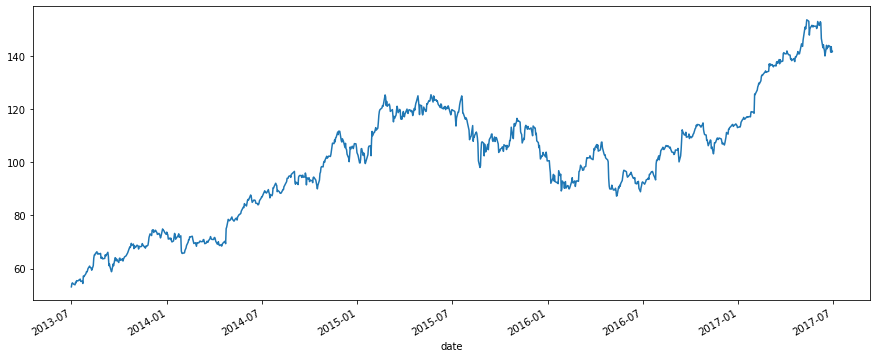

In [4]:
apple_ticker = 'AAPL'

close[apple_ticker].plot(figsize=(15,6));

## The Alpha Research Process

In this project you will code and evaluate a "breakout" signal. It is important to understand where these steps fit in the alpha research workflow. The signal-to-noise ratio in trading signals is very low and, as such, it is very easy to fall into the trap of _overfitting_ to noise. It is therefore inadvisable to jump right into signal coding. To help mitigate overfitting, it is best to start with a general observation and hypothesis; i.e., you should be able to answer the following question _before_ you touch any data:

> What feature of markets or investor behaviour would lead to a persistent anomaly that my signal will try to use?

Ideally the assumptions behind the hypothesis will be testable _before_ you actually code and evaluate the signal itself. The workflow therefore is as follows:

![image](images/alpha_steps.png)

In this project, we assume that the first three steps area done ("observe & research", "form hypothesis", "validate hypothesis"). The hypothesis you'll be using for this project is the following:
- In the absence of news or significant investor trading interest, stocks oscillate in a range.
- Traders seek to capitalize on this range-bound behaviour periodically by selling/shorting at the top of the range and buying/covering at the bottom of the range. This behaviour reinforces the existence of the range.
- When stocks break out of the range, due to, e.g., a significant news release or from market pressure from a large investor:
    - the liquidity traders who have been providing liquidity at the bounds of the range seek to cover their positions to mitigate losses, thus magnifying the move out of the range, _and_
    - the move out of the range attracts other investor interest; these investors, due to the behavioural bias of _herding_ (e.g., [Herd Behavior](https://www.investopedia.com/university/behavioral_finance/behavioral8.asp)) build positions which favor continuation of the trend.


Using this hypothesis, let start coding..
## Compute the Highs and Lows in a Window
You'll use the price highs and lows as an indicator for the breakout strategy. In this section, implement `get_high_lows_lookback` to get the maximum high price and minimum low price over a window of days. The variable `lookback_days` contains the number of days to look in the past. Make sure this doesn't include the current day.

In [5]:
def get_high_lows_lookback(high, low, lookback_days):
    """
    Get the highs and lows in a lookback window.
    
    Parameters
    ----------
    high : DataFrame
        High price for each ticker and date
    low : DataFrame
        Low price for each ticker and date
    lookback_days : int
        The number of days to look back
    
    Returns
    -------
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
    """
    
    # shifting one to exclude the current day, then looking at
    # a rolling lookback window and taking the max for high and min for low
    
    lookback_high = high.shift(1).rolling(lookback_days).max()
    lookback_low = low.shift(1).rolling(lookback_days).min()

    return lookback_high, lookback_low

#project_tests.test_get_high_lows_lookback(get_high_lows_lookback)

### View Data
Let's use your implementation of `get_high_lows_lookback` to get the highs and lows for the past 50 days and compare it to it their respective stock.  Just like last time, we'll use Apple's stock as the example to look at.

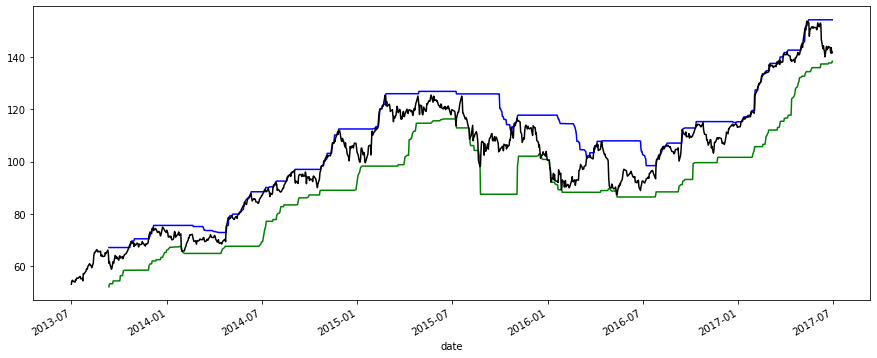

In [6]:
lookback_days = 50
lookback_high, lookback_low = get_high_lows_lookback(high, low, lookback_days)

lookback_high[apple_ticker].plot(figsize=(15,6), color="blue");
lookback_low[apple_ticker].plot(figsize=(15,6), color="green");

close[apple_ticker].plot(figsize=(15,6), color="black");


## Compute Long and Short Signals
Using the generated indicator of highs and lows, create long and short signals using a breakout strategy. Implement `get_long_short` to generate the following signals:

| Signal | Condition |
|----|------|
| -1 | Low > Close Price |
| 1  | High < Close Price |
| 0  | Otherwise |

In this chart, **Close Price** is the `close` parameter. **Low** and **High** are the values generated from `get_high_lows_lookback`, the `lookback_high` and `lookback_low` parameters.

In [7]:
def get_long_short(close, lookback_high, lookback_low):
    """
    Generate the signals long, short, and do nothing.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
    
    Returns
    -------
    long_short : DataFrame
        The long, short, and do nothing signals for each ticker and date
    """
    # initialize long_short signal DataFrame with integer zeros
    # taking the size, indexes and column names from the close DataFrame
    long_short = pd.DataFrame().reindex_like(close).fillna(0).astype('int')

    # use boolean indexing to "mark" the short signal in long_short with -1
    df_low = lookback_low.subtract(close)
    long_short[df_low > 0] = -1

    # use boolean indexing to "mark" the long signal in long_short with 1
    df_high = close.subtract(lookback_high)
    long_short[df_high > 0] = 1
    
    return long_short

#project_tests.test_get_long_short(get_long_short)

### View Data
Let's compare the signals you generated against the close prices. This chart will show a lot of signals. Too many in fact. We'll talk about filtering the redundant signals in the next problem. 

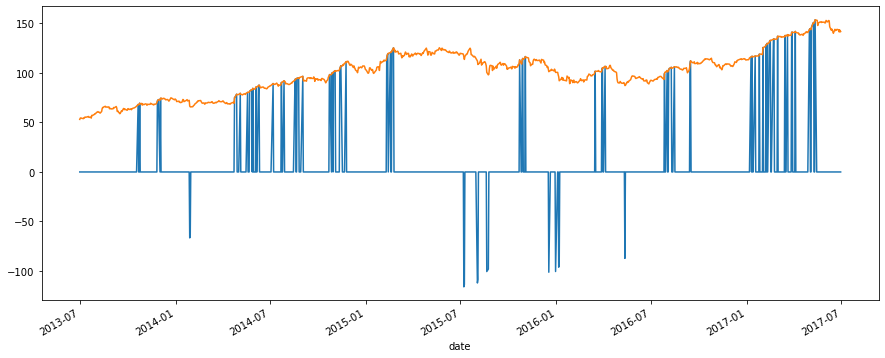

In [8]:
signal = get_long_short(close, lookback_high, lookback_low)

(close[apple_ticker]*signal[apple_ticker]).plot(figsize=(15,6));
close[apple_ticker].plot(figsize=(15,6));

## Filter Signals
That was a lot of repeated signals! If we're already shorting a stock, having an additional signal to short a stock isn't helpful for this strategy. This also applies to additional long signals when the last signal was long.

Implement `filter_signals` to filter out repeated long or short signals within the `lookahead_days`. If the previous signal was the same, change the signal to `0` (do nothing signal). For example, say you have a single stock time series that is

`[1, 0, 1, 0, 1, 0, -1, -1]`

Running `filter_signals` with a lookahead of 3 days should turn those signals into

`[1, 0, 0, 0, 1, 0, -1, 0]`

To help you implement the function, we have provided you with the `clear_signals` function. This will remove all signals within a window after the last signal. For example, say you're using a windows size of 3 with `clear_signals`. It would turn the Series of long signals

`[0, 1, 0, 0, 1, 1, 0, 1, 0]`

into

`[0, 1, 0, 0, 0, 1, 0, 0, 0]`

`clear_signals` only takes a Series of the same type of signals, where `1` is the signal and `0` is no signal. It can't take a mix of long and short signals. Using this function, implement `filter_signals`. 

For implementing `filter_signals`, we don't reccommend you try to find a vectorized solution. Instead, you should use the [`iterrows`](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.iterrows.html) over each column.

In [9]:
# Quick look at signal distribution for one of the stocks: Apple
signal.AAPL.value_counts()

 0    915
 1     81
-1     13
Name: AAPL, dtype: int64

In [10]:
def clear_signals(signals, window_size):
    """
    Clear out signals in a Series of just long or short signals.
    
    Remove the number of signals down to 1 within the window size time period.
    
    Parameters
    ----------
    signals : Pandas Series
        The long, short, or do nothing signals
    window_size : int
        The number of days to have a single signal       
    
    Returns
    -------
    signals : Pandas Series
        Signals with the signals removed from the window size
    """
    # Start with buffer of window size
    # This handles the edge case of calculating past_signal in the beginning
    clean_signals = [0]*window_size
    
    for signal_i, current_signal in enumerate(signals):
        # Check if there was a signal in the past window_size of days
        has_past_signal = bool(sum(clean_signals[signal_i:signal_i+window_size]))
        # Use the current signal if there's no past signal, else 0/False
        clean_signals.append(not has_past_signal and current_signal)
        
    # Remove buffer
    clean_signals = clean_signals[window_size:]

    # Return the signals as a Series of Ints
    return pd.Series(np.array(clean_signals).astype(np.int), signals.index)


def filter_signals(signal, lookahead_days):
    """
    Filter out signals in a DataFrame.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    filtered_signal : DataFrame
        The filtered long, short, and do nothing signals for each ticker and date
    """
    
    filtered_signal = signal.copy()
    
    for label, sig in signal.items():

        sig_pos = sig.copy()
        sig_neg = sig.copy()
        
        sig_pos[sig_pos == -1] = 0
        sig_neg[sig_neg == 1] = 0

        sig_pos = clear_signals(sig_pos, lookahead_days)
        sig_neg = clear_signals(sig_neg, lookahead_days)

        filtered_signal[label] = sig_pos + sig_neg
    
    return filtered_signal


#project_tests.test_filter_signals(filter_signals)

### View Data
Let's view the same chart as before, but with the redundant signals removed.

In [11]:
signal_5 = filter_signals(signal, 5)
signal_10 = filter_signals(signal, 10)
signal_20 = filter_signals(signal, 20)

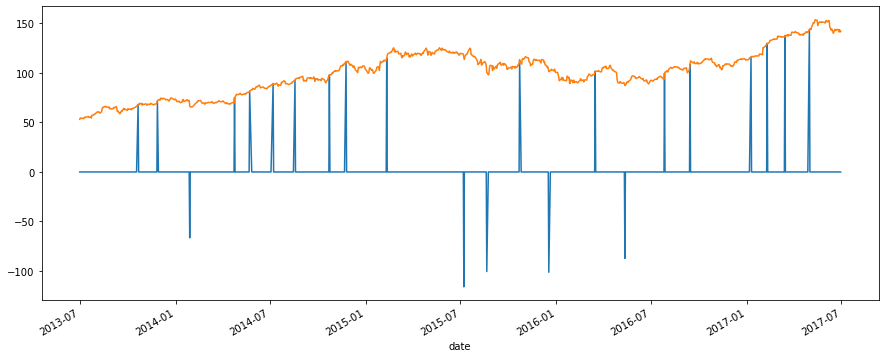

In [12]:
(close[apple_ticker]*signal_20[apple_ticker]).plot(figsize=(15,6));
close[apple_ticker].plot(figsize=(15,6));

## Lookahead Close Prices
With the trading signal done, we can start working on evaluating how many days to short or long the stocks. In this problem, implement `get_lookahead_prices` to get the close price days ahead in time. You can get the number of days from the variable `lookahead_days`. We'll use the lookahead prices to calculate future returns in another problem.

In [13]:
def get_lookahead_prices(close, lookahead_days):
    """
    Get the lookahead prices for `lookahead_days` number of days.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    """
    # get the lookahead prices
    lookahead_prices = close.shift(-1*lookahead_days)
    
    return lookahead_prices

#project_tests.test_get_lookahead_prices(get_lookahead_prices)

### View Data
Using the `get_lookahead_prices` function, let's generate lookahead closing prices for 5, 10, and 20 days.

Let's also chart a subsection of a few months of the Apple stock instead of years. This will allow you to view the differences between the 5, 10, and 20 day lookaheads. Otherwise, they will mesh together when looking at a chart that is zoomed out.

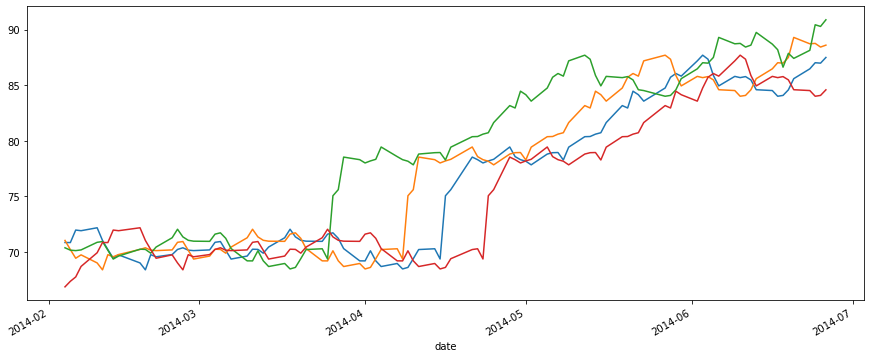

In [14]:
lookahead_5 = get_lookahead_prices(close, 5)
lookahead_10 = get_lookahead_prices(close, 10)
lookahead_20 = get_lookahead_prices(close, 20)


lookahead_5[apple_ticker].iloc[150:250].plot(figsize=(15,6));
lookahead_10[apple_ticker].iloc[150:250].plot(figsize=(15,6));
lookahead_20[apple_ticker].iloc[150:250].plot(figsize=(15,6));
close[apple_ticker].iloc[150:250].plot(figsize=(15,6));


In [15]:
lookahead_20.AAPL.iloc[150:250]

date
2014-02-04    70.371070
2014-02-05    70.158249
2014-02-06    70.117271
2014-02-07    70.180721
2014-02-10    70.864128
                ...    
2014-06-20    87.408962
2014-06-23    88.135672
2014-06-24    90.433973
2014-06-25    90.285095
2014-06-26    90.881537
Name: AAPL, Length: 100, dtype: float64

## Lookahead Price Returns
Implement `get_return_lookahead` to generate the log price return between the closing price and the lookahead price.

In [16]:
def get_return_lookahead(close, lookahead_prices):
    """
    Calculate the log returns from the lookahead days to the signal day.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    
    Returns
    -------
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    """
    
    lookahead_returns = np.log(lookahead_prices) - np.log(close)
    
    return lookahead_returns

#project_tests.test_get_return_lookahead(get_return_lookahead)

### View Data
Using the same lookahead prices and same subsection of the Apple stock from the previous problem, we'll view the lookahead returns.

In order to view price returns on the same chart as the stock, a second y-axis will be added. When viewing this chart, the axis for the price of the stock will be on the left side, like previous charts. The axis for price returns will be located on the right side.

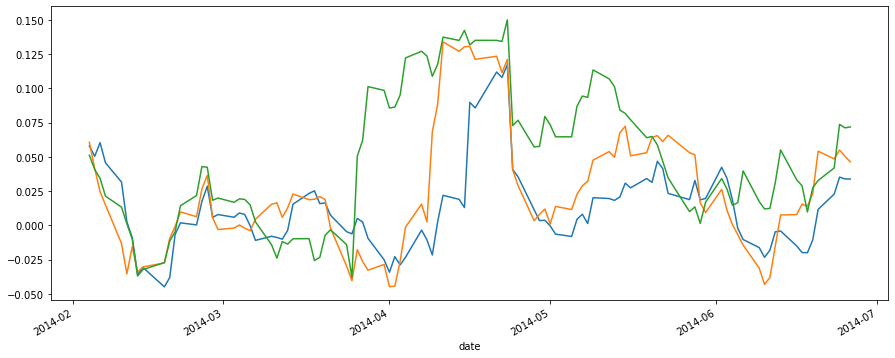

In [17]:
price_return_5 = get_return_lookahead(close, lookahead_5)
price_return_10 = get_return_lookahead(close, lookahead_10)
price_return_20 = get_return_lookahead(close, lookahead_20)

price_return_5[apple_ticker].iloc[150:250].plot(figsize=(15,6));
price_return_10[apple_ticker].iloc[150:250].plot(figsize=(15,6));
price_return_20[apple_ticker].iloc[150:250].plot(figsize=(15,6));
#close[apple_ticker].iloc[150:250].plot(figsize=(15,6));

## Compute the Signal Return
Using the price returns generate the signal returns.

In [18]:
def get_signal_return(signal, lookahead_returns):
    """
    Compute the signal returns.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    
    Returns
    -------
    signal_return : DataFrame
        Signal returns for each ticker and date
    """
    # calculating signal return
    signal_return = signal*lookahead_returns
    
    return signal_return

#project_tests.test_get_signal_return(get_signal_return)

### View Data
Let's continue using the previous lookahead prices to view the signal returns. Just like before, the axis for the signal returns is on the right side of the chart.

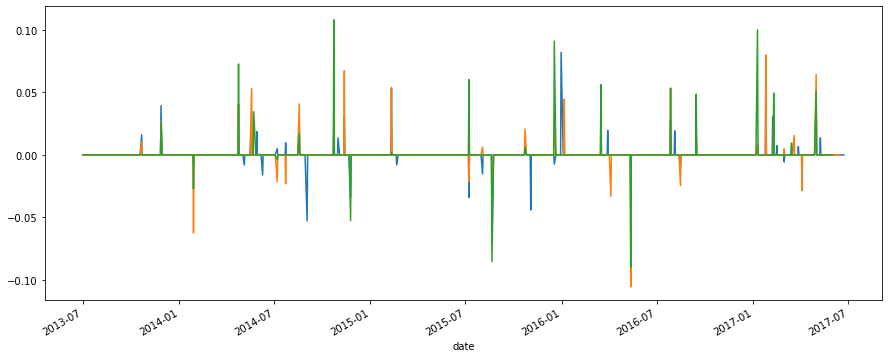

In [19]:
#title_string = '{} day LookaheadSignal Returns for {} Stock'

signal_return_5 = get_signal_return(signal_5, price_return_5)
signal_return_10 = get_signal_return(signal_10, price_return_10)
signal_return_20 = get_signal_return(signal_20, price_return_20)

signal_return_5[apple_ticker].plot(figsize=(15,6));
signal_return_10[apple_ticker].plot(figsize=(15,6));
signal_return_20[apple_ticker].plot(figsize=(15,6));

## Test for Significance
### Histogram
Let's plot a histogram of the signal return values.

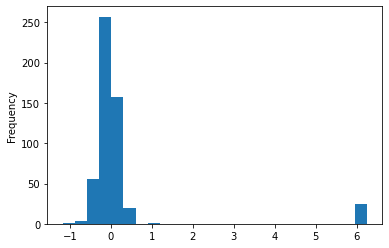

In [44]:
signal_return_5.sum().plot(kind='hist', bins=25);

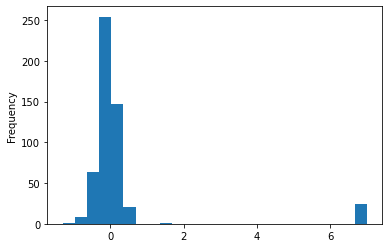

In [45]:
signal_return_10.sum().plot(kind='hist', bins=25);

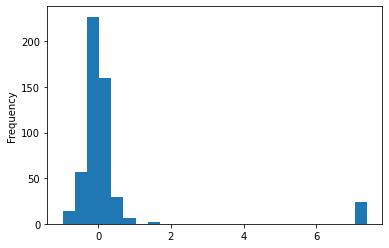

In [46]:
signal_return_20.sum().plot(kind='hist', bins=25);

### Question: What do the histograms tell you about the signal returns?

The histograms show that the distributions for 5, 10 and 20 days signal returns. It seems they all have a mean close to zero and a bell shaped curve. However, there is some irregularity in the right tail, especially for the 20 days return. So there must be outliers. Apart from that, the shape is fine, but we would wish that at least one of the distributions was shifted slightly to the right. A positive mean would indicate possible alpha.

## Outliers
You might have noticed the outliers in the 10 and 20 day histograms. To better visualize the outliers, let's compare the 5, 10, and 20 day signals returns to normal distributions with the same mean and deviation for each signal return distributions.

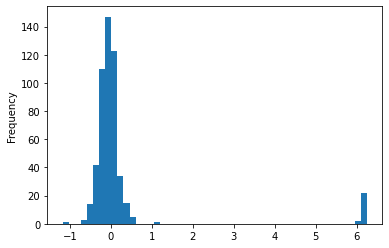

In [22]:
signal_return_5.sum().plot(kind='hist', bins=50);

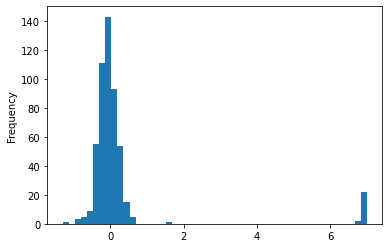

In [23]:
signal_return_10.sum().plot(kind='hist', bins=50);

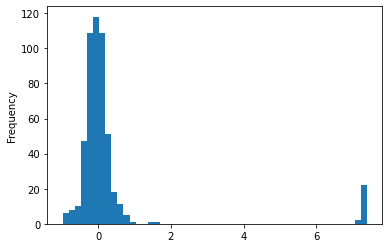

In [24]:
signal_return_20.sum().plot(kind='hist', bins=50);

The are clearly outliers in all; both the 5, 10, and 20 day signals returns

## Kolmogorov-Smirnov Test
While you can see the outliers in the histogram, we need to find the stocks that are causing these outlying returns. We'll use the Kolmogorov-Smirnov Test or KS-Test. This test will be applied to each ticker's signal returns where a long or short signal exits.

In [25]:
# Filter out returns that don't have a long or short signal.
long_short_signal_returns_5 = signal_return_5[signal_5 != 0].stack()
long_short_signal_returns_10 = signal_return_10[signal_10 != 0].stack()
long_short_signal_returns_20 = signal_return_20[signal_20 != 0].stack()

# Get just ticker and signal return
long_short_signal_returns_5 = long_short_signal_returns_5.reset_index().iloc[:, [1,2]]
long_short_signal_returns_5.columns = ['ticker', 'signal_return']
long_short_signal_returns_10 = long_short_signal_returns_10.reset_index().iloc[:, [1,2]]
long_short_signal_returns_10.columns = ['ticker', 'signal_return']
long_short_signal_returns_20 = long_short_signal_returns_20.reset_index().iloc[:, [1,2]]
long_short_signal_returns_20.columns = ['ticker', 'signal_return']

# View some of the data
long_short_signal_returns_5.head(10)

,ticker,signal_return
0,A,0.007326
1,ABC,0.016396
2,ADP,0.009815
3,AGENEN,0.025208
4,AKAM,0.044005
5,ALGN,0.015456
6,ALTAIC,0.030574
7,APC,0.003059
8,BA,0.080613
9,BCR,0.009334


This gives you the data to use in the KS-Test.

Now it's time to implement the function `calculate_kstest` to use Kolmogorov-Smirnov test (KS test) between a distribution of stock returns (the input dataframe in this case) and each stock's signal returns. Run KS test on a normal distribution against each stock's signal returns. Use [`scipy.stats.kstest`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html#scipy-stats-kstest) perform the KS test. When calculating the standard deviation of the signal returns, make sure to set the delta degrees of freedom to 0.

For this function, we don't reccommend you try to find a vectorized solution. Instead, you should iterate over the [`groupby`](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.groupby.html) function.

In [26]:
from scipy.stats import kstest


def calculate_kstest(long_short_signal_returns):
    """
    Calculate the KS-Test against the signal returns with a long or short signal.
    
    Parameters
    ----------
    long_short_signal_returns : DataFrame
        The signal returns which have a signal.
        This DataFrame contains two columns, "ticker" and "signal_return"
    
    Returns
    -------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    """
    # initialize ks_values_dict and p_values_dict
    ks_values_dict = dict()
    p_values_dict = dict()
    
    # calculate the mean and std of all signal returns
    sr_mean = long_short_signal_returns.signal_return.mean()
    sr_std = long_short_signal_returns.signal_return.std(ddof=0)
    
    for ticker, data in long_short_signal_returns.groupby('ticker'):

        # apply the kstest function to compare each ticker's dist with overall dist
        ks, p = kstest(data.signal_return,'norm', args=(sr_mean, sr_std))
 
        # add KS test statistic and p-value to the respective dictionaries
        ks_values_dict[ticker] = ks
        p_values_dict[ticker] = p

    return pd.Series(ks_values_dict), pd.Series(p_values_dict)
    

#project_tests.test_calculate_kstest(calculate_kstest)

### View Data
Using the signal returns we created above, let's calculate the ks and p values.

In [27]:
ks_values_5, p_values_5 = calculate_kstest(long_short_signal_returns_5)
ks_values_10, p_values_10 = calculate_kstest(long_short_signal_returns_10)
ks_values_20, p_values_20 = calculate_kstest(long_short_signal_returns_20)

print('ks_values_5')
print(ks_values_5.head(10))
print('p_values_5')
print(p_values_5.head(10))

ks_values_5
A       0.171552
AAL     0.107514
AAP     0.196390
AAPL    0.155899
ABBV    0.167581
ABC     0.214190
ABT     0.213148
ACN     0.281690
ADBE    0.242164
ADI     0.193801
dtype: float64
p_values_5
A       0.189966
AAL     0.690300
AAP     0.046016
AAPL    0.245159
ABBV    0.249946
ABC     0.027254
ABT     0.049280
ACN     0.005984
ADBE    0.009335
ADI     0.100358
dtype: float64


## Find Outliers
With the ks and p values calculate, let's find which symbols are the outliers. Implement the `find_outliers` function to find the following outliers:
- Symbols that pass the null hypothesis with a p-value less than `pvalue_threshold` **AND** with a KS value above `ks_threshold`.

*Note: your function should return symbols that meet both requirements above.*

In [28]:
def find_outliers(ks_values, p_values, ks_threshold, pvalue_threshold=0.05):
    """
    Find outlying symbols using KS values and P-values
    
    Parameters
    ----------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    ks_threshold : float
        The threshold for the KS statistic
    pvalue_threshold : float
        The threshold for the p-value
    
    Returns
    -------
    outliers : set of str
        Symbols that are outliers
    """
    # initialise set of outliers
    outliers = set()
    
    # loop through tickers
    for ticker, _ in ks_values.items():
        
        # Add to set of outliers all tickers that
        # pass the null hypothesis with both 
        # a p-value less than pvalue_threshold 
        # AND with a KS value above ks_threshold
        
        if ks_values[ticker] > ks_threshold and p_values[ticker] < pvalue_threshold:
            
            outliers.add(ticker)
            
        
    return outliers


#project_tests.test_find_outliers(find_outliers)

### View Data
Using the `find_outliers` function you implemented, let's see what we found.

In [29]:
ks_threshold = 0.8
outliers_5 = find_outliers(ks_values_5, p_values_5, ks_threshold)
outliers_10 = find_outliers(ks_values_10, p_values_10, ks_threshold)
outliers_20 = find_outliers(ks_values_20, p_values_20, ks_threshold)

outlier_tickers = outliers_5.union(outliers_10).union(outliers_20)
print('{} Outliers Found:\n{}'.format(len(outlier_tickers), ', '.join(list(outlier_tickers))))

24 Outliers Found:
HUMILI, GESNER, KOLPAK, TURKES, LINIFO, KAUFMA, SAXATI, TARDA, ARMENA, CLUSIA, URUMIE, AGENEN, VVEDEN, SCHREN, BIFLOR, ALTAIC, PRAEST, BAKERI, DASYST, ORPHAN, PULCHE, SPRENG, SYLVES, GREIGI


### Show Significance without Outliers
Let's compare the 5, 10, and 20 day signals returns without outliers to normal distributions. Also, let's see how the P-Value has changed with the outliers removed.

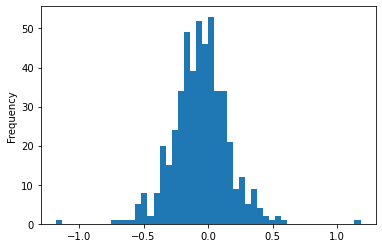

In [30]:
good_tickers = list(set(close.columns) - outlier_tickers)

signal_return_5[good_tickers].sum().plot(kind='hist', bins=50);



That's more like it! The returns are closer to a normal distribution. You have finished the research phase of a Breakout Strategy. You can now submit your project.
## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.